In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn import neighbors
from sklearn import model_selection
from sklearn import ensemble
!pip install scikit-learn --upgrade 

In [154]:
'HDF ist ein deutlich besseres Format als csv/txt/... -> Dateitypen + Index bleibt erhalten '
pollution = pd.read_hdf("Pollution_Data/pollutant_data.h5")
predictor = pd.read_hdf("Predictor_Data/all.h5")
#predictor.info()
predictor.columns

Index(['mean_wind_speed', 'max_value_wind_speed', 'max_hour_wind_speed',
       'mean_wind_direction', 'max_value_wind_direction',
       'max_hour_wind_direction', 'mean_temp', 'max_value_temp',
       'max_hour_temp', 'mean_humidity', 'max_value_humidity',
       'max_hour_humidity', 'mean_radiation', 'max_value_radiation',
       'max_hour_radiation', 'mean_uv_radiation', 'max_value_uv_radiation',
       'max_hour_uv_radiation', 'mean_pressure', 'max_value_pressure',
       'max_hour_pressure', 'rain', 't_max', 't_min', 'rain_bool', 't_minmax',
       'demand_electricity', 'net_generation_electricity', 'day_of_week',
       'month', 'quarter', 'year', 'business_day', 'temp_bool', 'wind_bool',
       'humidity_bool', 'radiation_bool', 'tminmax_bool'],
      dtype='object')

In [198]:
pollution.columns

Index(['mean_co', 'max_value_co', 'max_hour_co', 'mean_so2', 'max_value_so2',
       'max_hour_so2', 'mean_no2', 'max_value_no2', 'max_hour_no2', 'mean_o3',
       'max_value_o3', 'max_hour_o3', 'mean_pm2_5', 'aqi_pm2_5', 'aqi_so2',
       'aqi_no2', 'aqi_o3', 'aqi_idxmax', 'aqi_max'],
      dtype='object')

In [165]:
#nur numerische Columns (ohne wind_direction da in Grad, ohne UV_radiation da sehr ähnlich zu radiation)
# auch ohne elektricity denn dadurch mehr Daten
numeric_columns=['mean_wind_speed', 'max_value_wind_speed', 'max_hour_wind_speed', 'mean_temp', 'max_value_temp',
       'max_hour_temp', 'mean_humidity', 'max_value_humidity',
       'max_hour_humidity', 'mean_radiation', 'max_value_radiation',
       'max_hour_radiation', 
        'mean_pressure', 'max_value_pressure',
       'max_hour_pressure', 'rain', 't_max', 't_min', 't_minmax',  'business_day']

quarter_dummi= pd.get_dummies(predictor["quarter"],prefix="quarter")
wind_dummi= pd.get_dummies(predictor["mean_wind_direction"],prefix="wind")
predict_today=predictor[numeric_columns]
predict_today = predict_today.join(quarter_dummi)
predict_today = predict_today.join(wind_dummi)

predict_today["business_day"]= predict_today["business_day"].astype(np.uint8)

# hinzufügen der Schadstoff Werte (ohne max_hour)
predict_today = predict_today.join(pollution.drop(['max_hour_co', 'max_hour_so2',
                                                   'max_hour_no2','max_hour_o3',"aqi_idxmax","aqi_max"],axis=1))

predict_today_dropna=predict_today.dropna()
predict_today_dropna.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1275 entries, 2015-04-01 to 2019-12-31
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   mean_wind_speed       1275 non-null   float64 
 1   max_value_wind_speed  1275 non-null   float64 
 2   max_hour_wind_speed   1275 non-null   float64 
 3   mean_temp             1275 non-null   float64 
 4   max_value_temp        1275 non-null   float64 
 5   max_hour_temp         1275 non-null   float64 
 6   mean_humidity         1275 non-null   float64 
 7   max_value_humidity    1275 non-null   float64 
 8   max_hour_humidity     1275 non-null   float64 
 9   mean_radiation        1275 non-null   float64 
 10  max_value_radiation   1275 non-null   float64 
 11  max_hour_radiation    1275 non-null   float64 
 12  mean_pressure         1275 non-null   float64 
 13  max_value_pressure    1275 non-null   float64 
 14  max_hour_pressure     1275 non-null   

[IterativeImputer] Completing matrix with shape (4017, 20)
[IterativeImputer] Change: 66.64872594212545, scaled tolerance: 1.317 
[IterativeImputer] Change: 43.8360172053147, scaled tolerance: 1.317 
[IterativeImputer] Change: 36.66441711471834, scaled tolerance: 1.317 
[IterativeImputer] Change: 30.251580172739068, scaled tolerance: 1.317 
[IterativeImputer] Change: 26.10505777688959, scaled tolerance: 1.317 
[IterativeImputer] Change: 22.5612552217351, scaled tolerance: 1.317 
[IterativeImputer] Change: 19.631087703783244, scaled tolerance: 1.317 
[IterativeImputer] Change: 17.043103233604768, scaled tolerance: 1.317 
[IterativeImputer] Change: 14.696322920962261, scaled tolerance: 1.317 
[IterativeImputer] Change: 12.611304458615797, scaled tolerance: 1.317 
[IterativeImputer] Change: 10.768470505804341, scaled tolerance: 1.317 
[IterativeImputer] Change: 9.158513027023826, scaled tolerance: 1.317 
[IterativeImputer] Change: 7.769501935671726, scaled tolerance: 1.317 
[IterativeImpu

In [6]:
predict_today["max_value_o3"].describe()

count    1275.000000
mean       96.219451
std        28.966362
min         7.700000
25%        77.000000
50%        94.300000
75%       113.500000
max       223.200000
Name: max_value_o3, dtype: float64

In [79]:
#vorher Standartisieren
col_to_scale=[     'mean_wind_speed', 'max_value_wind_speed',  'max_hour_wind_speed',
                  'mean_temp',       'max_value_temp',        'max_hour_temp',
              'mean_humidity',   'max_value_humidity',    'max_hour_humidity',
             'mean_radiation',  'max_value_radiation',   'max_hour_radiation',
              'mean_pressure',   'max_value_pressure',    'max_hour_pressure',
                       'rain',                't_max',                't_min',
                   't_minmax',              'mean_co',
               'max_value_co',             'mean_so2',        'max_value_so2',
                   'mean_no2',        'max_value_no2',              'mean_o3',
               'max_value_o3',           'mean_pm2_5']
st_scaler=StandardScaler()
predict_today_dropna[col_to_scale] = st_scaler.fit_transform(predict_today_dropna[col_to_scale])

predict_column="max_value_o3"
X_train , X_test , y_train , y_test = train_test_split(predict_today_dropna.drop(['aqi_pm2_5','aqi_so2',
                                                                           'aqi_no2','aqi_o3',predict_column,"mean_o3"],axis=1),
                                                       predict_today_dropna[predict_column])



Score of the model: 0.7005681940511852


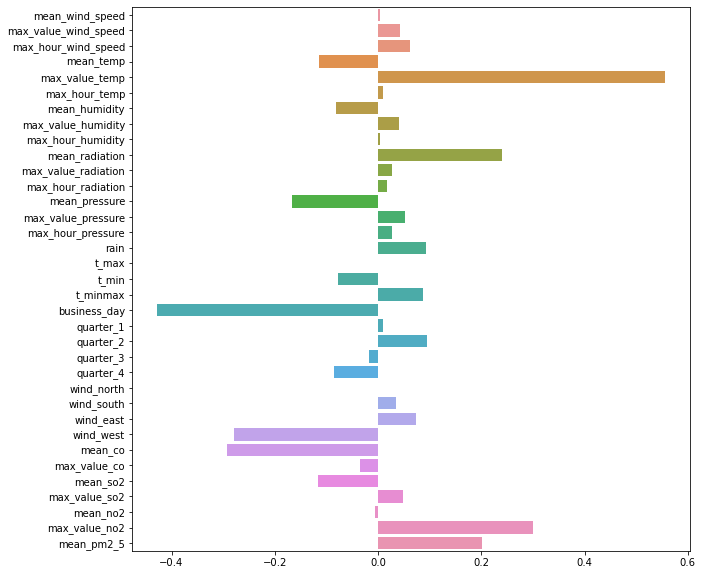

In [8]:
#einfachstes Modell -> linear
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
score= lin_reg.score(X_test,y_test)
print(f"Score of the model: {score}")
fig_coef, ax_coef = plt.subplots(1,1,figsize=(10,10))
ax_coef = sns.barplot(y=X_train.columns,x=lin_reg.coef_,orient="h")

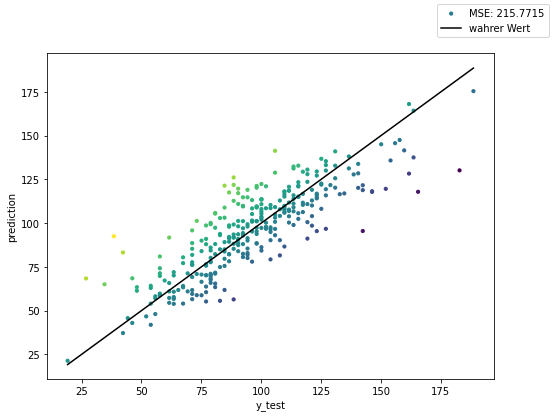

In [9]:
lin_reg_fig, lin_reg_ax= plt.subplots(1,1,figsize=(8,6))

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = lin_reg.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true

mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
lin_reg_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
lin_reg_ax.plot(x,x,c="black",label="wahrer Wert")
lin_reg_ax.set_xlabel("y_test")
lin_reg_ax.set_ylabel("prediction")
lin_reg_fig.legend()


Score of the model: 0.7011057458891675


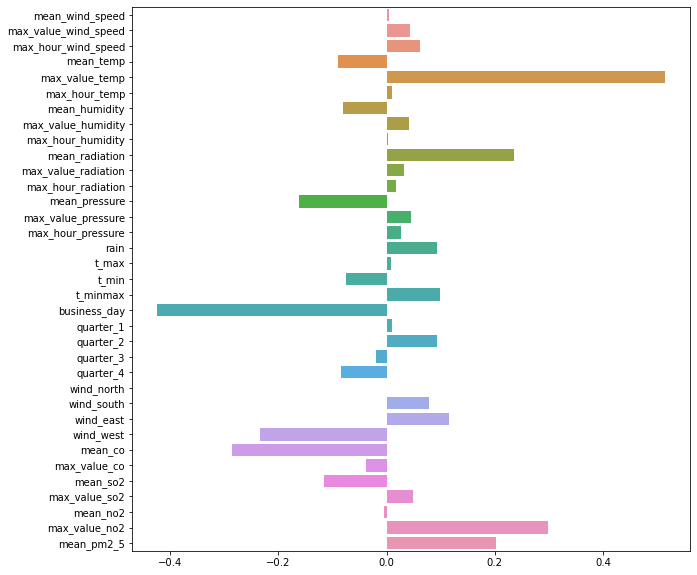

In [10]:
#einfachstes Modell -> linear Ridge
ridge_reg=Ridge()
ridge_reg.fit(X_train,y_train)
score= ridge_reg.score(X_test,y_test)
print(f"Score of the model: {score}")

fig_coef, ax_coef = plt.subplots(1,1,figsize=(10,10))
ax_coef = sns.barplot(y=X_train.columns,x=ridge_reg.coef_,orient="h")


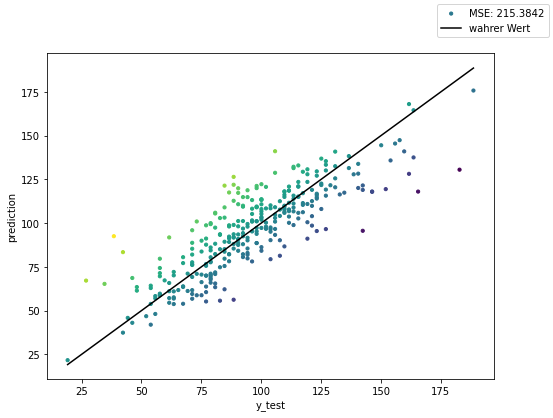

In [11]:
ridge_fig, ridge_ax= plt.subplots(1,1,figsize=(8,6))

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = ridge_reg.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true
mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
ridge_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
ridge_ax.plot(x,x,c="black",label="wahrer Wert")
ridge_ax.set_xlabel("y_test")
ridge_ax.set_ylabel("prediction")
ridge_fig.legend()

## supervised Clustering with aqi_o3

In [73]:
predict_column="aqi_o3"
X_train_classify , X_test_classify , y_train_classify , y_test_classify = train_test_split(predict_today.drop(['aqi_pm2_5','aqi_so2',
                                                                           'aqi_no2',predict_column,"mean_o3","max_value_o3"],axis=1),
                                                       predict_today[predict_column],random_state=1)
y_test_classify

2018-11-30        Fair
2018-08-10        Fair
2017-07-07        Poor
2018-04-05    Moderate
2016-06-04        Poor
                ...   
2017-11-26    Moderate
2017-10-13    Moderate
2018-11-22        Fair
2018-05-30        Fair
2017-10-02    Moderate
Name: aqi_o3, Length: 319, dtype: category
Categories (6, object): ['Good' < 'Fair' < 'Moderate' < 'Poor' < 'Very Poor' < 'Extremely Poor']

In [13]:
rfc = RandomForestClassifier(max_depth=200,min_samples_split=10)
rfc.fit(X_train_classify,y_train_classify)
score= rfc.score(X_test_classify,y_test_classify)
print(f"Score of the model: {score}")


Score of the model: 0.7115987460815048


 balanced score of the model: 0.49889535935258905


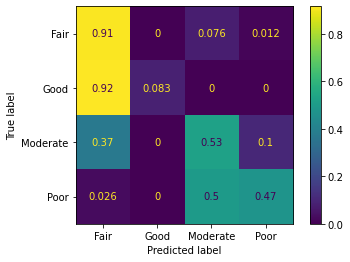

In [14]:
model=rfc
y_predict=model.predict(X_test_classify)
score_balanced= balanced_accuracy_score(y_true=y_test_classify,y_pred=y_predict)
print(f" balanced score of the model: {score_balanced}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

Für andere Classifikationen wird vorher eine PCA gemacht. 

In [15]:
knn_solo=neighbors.KNeighborsClassifier()
param={
    'n_neighbors': [2, 4, 6, 8],
    'weights': ['uniform', 'distance'],
    "metric" : ["cityblock","l2","cosine"]
    }
knn_search= model_selection.GridSearchCV(knn_solo,param,n_jobs=4,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted")
knn_search.fit(X_train_classify,y_train_classify)
knn_search_result=pd.DataFrame(knn_search.cv_results_)


 balanced score of the model: 0.5420436228531195
f1-Score: 0.6965959090903283


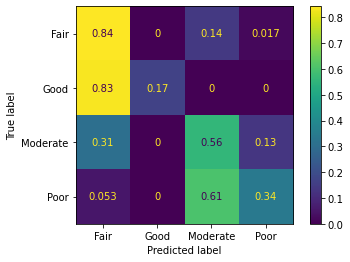

In [16]:
model=knn_search
y_predict=model.predict(X_test_classify)
score_balanced= knn_search_result.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f" balanced score of the model: {score_balanced}")
f1=knn_search_result.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {f1}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

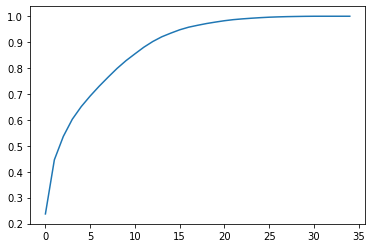

In [17]:
pca=decomposition.PCA()
'Important: only fit train data'
pca.fit(X_train_classify)

X_train_classify_pca=pca.transform(X_train_classify)
X_test_classify_pca=pca.transform(X_test_classify)

plt.plot(np.cumsum(pca.explained_variance_ratio_))


Gridsearch mit PCA und KNN -> dafür wird eine Pipeline erstellt
wie im [Beispiel](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html) hier 
- Welche Metric ist die beste für Classifizierung ? [Medium Artikel](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)

In [18]:
pca_pipeline=decomposition.PCA()
knn_pipeline=neighbors.KNeighborsClassifier()

pipe=Pipeline(steps=[("pca",pca_pipeline),("knn",knn_pipeline)])
param={
    "pca__n_components": [1,4,8,11,12,13,14,15,16,17,23,30],
    'knn__n_neighbors': [2, 4, 6, 8],
    'knn__weights': ['uniform', 'distance'],
    "knn__metric" : ["cityblock","l2","cosine"]
    }
pca_knn_search= model_selection.GridSearchCV(pipe,param,n_jobs=4,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted")
pca_knn_search.fit(X_train_classify,y_train_classify)


/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 268, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 2098, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/home/felix/anaconda3/lib/python3.9/site-packages/

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__metric': ['cityblock', 'l2', 'cosine'],
                         'knn__n_neighbors': [2, 4, 6, 8],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [1, 4, 8, 11, 12, 13, 14, 15, 16,
                                               17, 23, 30]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy', 'recall'])

In [30]:
pca_knn_search_result=pd.DataFrame(pca_knn_search.cv_results_)
pca_knn_search_result.drop(['params', 'split0_test_f1_weighted',
       'split1_test_f1_weighted', 'split2_test_f1_weighted',
       'split3_test_f1_weighted', 'split4_test_f1_weighted','split0_test_balanced_accuracy',
       'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy',
       'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy','split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy'],axis=1).sort_values("rank_test_balanced_accuracy").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,param_pca__n_components,mean_test_f1_weighted,std_test_f1_weighted,...,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.079127,0.015787,0.129764,0.055109,cityblock,2,uniform,1,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
195,0.092732,0.022434,0.131097,0.056278,cosine,2,uniform,11,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
194,0.086372,0.016515,0.169900,0.024310,cosine,2,uniform,8,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
193,0.071244,0.033266,0.148320,0.048069,cosine,2,uniform,4,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
192,0.072859,0.035221,0.123427,0.048699,cosine,2,uniform,1,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [20]:
pca_knn_search

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__metric': ['cityblock', 'l2', 'cosine'],
                         'knn__n_neighbors': [2, 4, 6, 8],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [1, 4, 8, 11, 12, 13, 14, 15, 16,
                                               17, 23, 30]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy', 'recall'])

The best parameters of the model are:
{'knn__metric': 'cityblock', 'knn__n_neighbors': 2, 'knn__weights': 'uniform', 'pca__n_components': 1}
{'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted), 'balanced_accuracy': make_scorer(balanced_accuracy_score), 'accuracy': make_scorer(accuracy_score), 'recall': make_scorer(recall_score, average=binary)}
score of the model: nan
balanced score of the model: nan
f1-Score: 0.6966


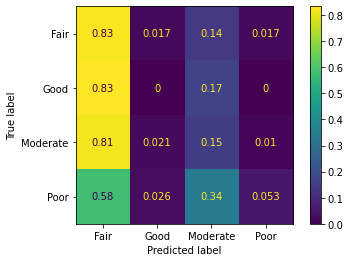

In [40]:
'Choose your model with tuned parameter with GridSearchCV'
model=pca_knn_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_classify)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")
'Print the scores'
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(f1,5)}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

In [109]:
gbc=ensemble.GradientBoostingClassifier(random_state=1)
gbc_params={
    "gbc__loss":["log_loss"],
    "gbc__n_estimators":[100,150],
    "gbc__max_depth":[2], #2 is the best
    "gbc__learning_rate":[0.1] #0.1 is the best
    }

pipeline_aqio3=Pipeline([("scaler",StandardScaler()),("gbc",gbc)])
gbc_seach=model_selection.GridSearchCV(estimator=pipeline_aqio3,param_grid=gbc_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4)
gbc_seach.fit(X_train_classify,y_train_classify)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=100; total time=   4.1s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=100; total time=   5.7s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=100; total time=   4.0s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=100; total time=   5.9s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=100; total time=   5.5s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=150; total time=   5.8s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=150; total time=  10.3s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=150; total time=   8.9s
[CV] END gbc__learning_rate=0.1, gbc

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbc',
                                        GradientBoostingClassifier(random_state=1))]),
             n_jobs=4,
             param_grid={'gbc__learning_rate': [0.1], 'gbc__loss': ['log_loss'],
                         'gbc__max_depth': [2],
                         'gbc__n_estimators': [100, 150]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'gbc__learning_rate': 0.1, 'gbc__loss': 'log_loss', 'gbc__max_depth': 2, 'gbc__n_estimators': 150}
score of the model: 0.74166
balanced score of the model: 0.59808
f1-Score: 0.6966


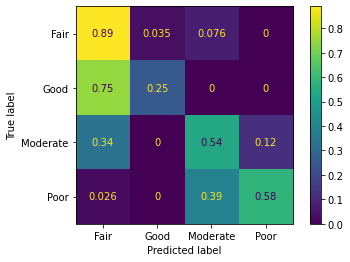

In [110]:
'Choose your model with tuned parameter with GridSearchCV'
model=gbc_seach

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_classify)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")
'Print the scores'
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(f1,5)}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

In [119]:
gbc_seach.best_estimator_["gbc"]

GradientBoostingClassifier(max_depth=2, n_estimators=150, random_state=1)

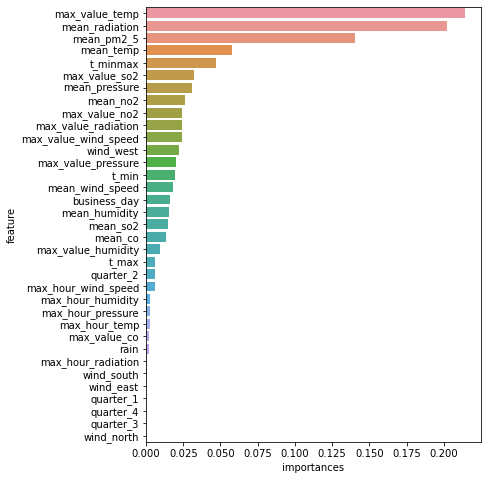

In [121]:
gbc_data=pd.DataFrame(data={"importances":gbc_seach.best_estimator_["gbc"].feature_importances_,"feature":gbc_seach.best_estimator_.feature_names_in_})
gbc_data=gbc_data.sort_values("importances",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,8))
ax=sns.barplot(x=gbc_data["importances"],y=gbc_data.feature,orient="h")


## Klappt dieses Modell auch für AQI_NO2 ? 

In [224]:
'Try to input missing values'
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
col_tofill=['mean_wind_speed', 'max_value_wind_speed', 'max_hour_wind_speed', 'mean_temp', 'max_value_temp',
       'max_hour_temp', 'mean_humidity', 'max_value_humidity',
       'max_hour_humidity', 'mean_radiation', 'max_value_radiation',
       'max_hour_radiation', 
        'mean_pressure', 'max_value_pressure',
       'max_hour_pressure', 'rain', 't_max', 't_min', 't_minmax',  'business_day']
predict_na_filled=predict_today
predict_na_filled= pd.DataFrame(IterativeImputer(verbose=1,max_iter=30).fit_transform(predict_today[col_tofill]),columns=col_tofill,index=predict_today.index)
predict_na_filled = predict_na_filled.join(pollution[['mean_co','max_value_co']])
predict_na_filled[predict_na_filled.columns] = StandardScaler().fit_transform(predict_na_filled)
predict_na_filled = predict_na_filled.join(pollution[["aqi_max","aqi_no2","aqi_o3","aqi_pm2_5"]])
predict_na_filled = predict_na_filled.dropna()
predict_na_filled.info()

[IterativeImputer] Completing matrix with shape (4017, 20)
[IterativeImputer] Change: 66.64872594212545, scaled tolerance: 1.317 
[IterativeImputer] Change: 43.8360172053147, scaled tolerance: 1.317 
[IterativeImputer] Change: 36.66441711471834, scaled tolerance: 1.317 
[IterativeImputer] Change: 30.251580172739068, scaled tolerance: 1.317 
[IterativeImputer] Change: 26.10505777688959, scaled tolerance: 1.317 
[IterativeImputer] Change: 22.5612552217351, scaled tolerance: 1.317 
[IterativeImputer] Change: 19.631087703783244, scaled tolerance: 1.317 
[IterativeImputer] Change: 17.043103233604768, scaled tolerance: 1.317 
[IterativeImputer] Change: 14.696322920962261, scaled tolerance: 1.317 
[IterativeImputer] Change: 12.611304458615797, scaled tolerance: 1.317 
[IterativeImputer] Change: 10.768470505804341, scaled tolerance: 1.317 
[IterativeImputer] Change: 9.158513027023826, scaled tolerance: 1.317 
[IterativeImputer] Change: 7.769501935671726, scaled tolerance: 1.317 
[IterativeImpu

In [225]:
predict_column="aqi_o3"

predict_na_filled.info()
X_train_aqino2 , X_test_aqino2 , y_train_aqino2 , y_test_aqino2 = train_test_split(predict_na_filled.drop(["aqi_max","aqi_no2","aqi_o3","aqi_pm2_5"],axis=1),
                                                       predict_na_filled[predict_column],random_state=1)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3098 entries, 2010-01-01 to 2022-06-30
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   mean_wind_speed       3098 non-null   float64 
 1   max_value_wind_speed  3098 non-null   float64 
 2   max_hour_wind_speed   3098 non-null   float64 
 3   mean_temp             3098 non-null   float64 
 4   max_value_temp        3098 non-null   float64 
 5   max_hour_temp         3098 non-null   float64 
 6   mean_humidity         3098 non-null   float64 
 7   max_value_humidity    3098 non-null   float64 
 8   max_hour_humidity     3098 non-null   float64 
 9   mean_radiation        3098 non-null   float64 
 10  max_value_radiation   3098 non-null   float64 
 11  max_hour_radiation    3098 non-null   float64 
 12  mean_pressure         3098 non-null   float64 
 13  max_value_pressure    3098 non-null   float64 
 14  max_hour_pressure     3098 non-null   

In [219]:
gbc=ensemble.GradientBoostingClassifier(random_state=1)
gbc_params={
    "loss":["log_loss"],
    "n_estimators":[200],
    "max_depth":[2], #2 is the best
    "learning_rate":[0.1] #0.1 is the best
    }

gbc_no2_search=model_selection.GridSearchCV(estimator=gbc,param_grid=gbc_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4,cv=5)
gbc_no2_search.fit(X_train_aqino2,y_train_aqino2)


Fitting 20 folds for each of 1 candidates, totalling 20 fits


/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=20.
  warnings.warn(


[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  17.4s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  17.3s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  17.1s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  19.5s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  18.3s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  17.7s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  17.8s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  16.3s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  16.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  18.9s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=2

GridSearchCV(cv=20, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.1], 'loss': ['log_loss'],
                         'max_depth': [2], 'n_estimators': [200]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 2, 'n_estimators': 200}
score of the model: 0.69825
balanced score of the model: 0.52329
f1-Score: 0.6966


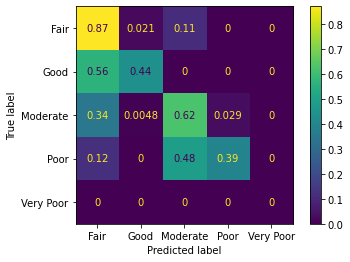

In [220]:
'Choose your model with tuned parameter with GridSearchCV'
model=gbc_no2_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_aqino2)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")
'Print the scores'
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(f1,5)}")

cm=confusion_matrix(y_true=y_test_aqino2,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

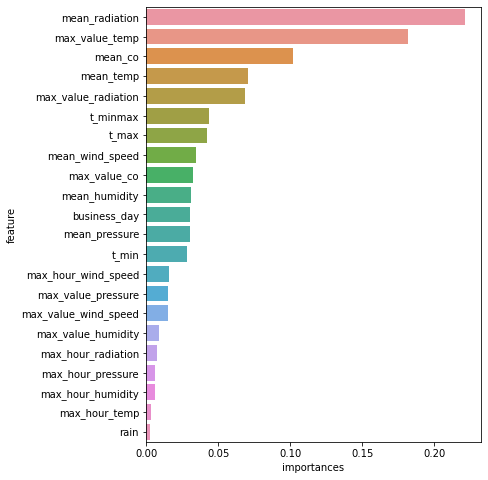

In [221]:
gbc_data=pd.DataFrame(data={"importances":gbc_no2_search.best_estimator_.feature_importances_,"feature":gbc_no2_search.best_estimator_.feature_names_in_})
gbc_data=gbc_data.sort_values("importances",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,8))
ax=sns.barplot(x=gbc_data["importances"],y=gbc_data.feature,orient="h")

## Predict the max AQI Index

In [227]:
predict_column="aqi_max"
X_train_aqimax , X_test_aqimax , y_train_aqimax , y_test_aqimax = train_test_split(predict_na_filled.drop(["aqi_max","aqi_no2","aqi_o3","aqi_pm2_5"],axis=1),
                                                       predict_na_filled[predict_column],random_state=1)


In [228]:
gbc=ensemble.GradientBoostingClassifier(random_state=1)
gbc_params={
    "loss":["log_loss"],
    "n_estimators":[200],
    "max_depth":[2], #2 is the best
    "learning_rate":[0.1] #0.1 is the best
    }

gbc_no2_search=model_selection.GridSearchCV(estimator=gbc,param_grid=gbc_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4,cv=5)
gbc_no2_search.fit(X_train_aqimax,y_train_aqimax)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  14.3s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  16.7s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  19.4s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  21.0s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  12.2s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.1], 'loss': ['log_loss'],
                         'max_depth': [2], 'n_estimators': [200]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 2, 'n_estimators': 200}
score of the model: 0.68575
balanced score of the model: 0.45276
f1-Score: 0.6966


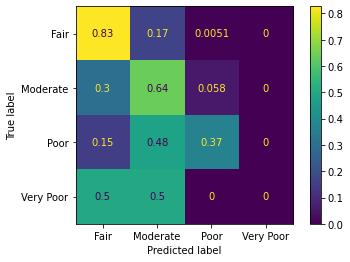

In [229]:
'Choose your model with tuned parameter with GridSearchCV'
model=gbc_no2_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_aqimax)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")
'Print the scores'
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(f1,5)}")

cm=confusion_matrix(y_true=y_test_aqimax,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

In [ ]:
gbc_data=pd.DataFrame(data={"importances":gbc_no2_search.best_estimator_.feature_importances_,"feature":gbc_no2_search.best_estimator_.feature_names_in_})
gbc_data=gbc_data.sort_values("importances",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,8))
ax=sns.barplot(x=gbc_data["importances"],y=gbc_data.feature,orient="h")